In [1]:
!pip install qiskit
!pip install qiskit-Aer
!pip install qiskit-ibm-runtime
!pip install qiskit_machine_learning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 28.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    U

In [2]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit.circuit.library import StatePreparation
import numpy as np
import networkx as nx
import random

In [3]:
node_to_idx = {
    'Male': '000', 
    'Addu_City': '100', 
    'Fuvahmulah': '010', 
    'Kulhudhuffushi': '110', 
    'Thinadhoo': '001', 
    'Naifaru': '101'
}
idx_to_node = {
    '000':'Male',
    '100':'Addu_City', 
    '010':'Fuvahmulah', 
    '110':'Kulhudhuffushi',
    '001':'Thinadhoo', 
    '101':'Naifaru'
}
node_values_raw = {
    'Male': 7, 
    'Addu_City': 4, 
    'Fuvahmulah': 3, 
    'Kulhudhuffushi': 2, 
    'Thinadhoo': 2, 
    'Naifaru': 1
}

edge_distances_raw = {
    'Male':
        {'Addu_City': 4, 
         'Fuvahmulah': 3,
         'Kulhudhuffushi': 4,
         'Thinadhoo': 2,
         'Naifaru': 2},
    'Addu_City':
        {'Fuvahmulah':1,
         'Kulhudhuffushi':7,
         'Thinadhoo':3,
         'Naifaru':5},
    'Fuvahmulah': 
        {'Kulhudhuffushi':5,
         'Thinadhoo':2,
         'Naifaru':4}, 
    'Kulhudhuffushi':
        {'Thinadhoo':4,
         'Naifaru':2},
    'Thinadhoo':
        {'Naifaru':4}
}

positions_raw = {
    'Kulhudhuffushi': (0, 16),
    'Naifaru': (0.25, 15), 
    'Male': (0.55, 11), 
    'Thinadhoo': (0.95, 6),
    'Fuvahmulah': (1.6, 4),
    'Addu_City': (2.2, 2)
}
edge_distances = {node_to_idx[src]: {node_to_idx[dest]: dist for dest, dist in val.items()} for src, val in edge_distances_raw.items()}
node_values = {node_to_idx[node]: val for node, val in node_values_raw.items()}
positions = {node_to_idx[src]: pos for src, pos in positions_raw.items()}
# Set capacities
node_capacities = {}
for node, value in node_values.items():
    node_capacities[node] = min(random.randint(value + 1, max(int(1.5 * value), value+2)), 7)


# Typhoon hits Male, capacity reduced
node_capacities[node_to_idx['Male']] = 0

print("Node Capacities:", node_capacities)


Node Capacities: {'000': 0, '100': 5, '010': 5, '110': 3, '001': 4, '101': 2}


In [4]:
# Create a reduced adjacency matrix for distances ≤3
adjacency_list = {}
for src, sinks in edge_distances.items():
    adjacency_list[src] = {sink: dist for sink, dist in sinks.items() if dist <= 3}

node_valencies = {node: 0 for node in node_capacities.keys()}
for src, adj in adjacency_list.items():
    for dest in adj.keys():
        node_valencies[src] += 1
        node_valencies[dest] += 1


num_positions = len(node_values)
num_position_qubits = int(np.ceil(np.log2(num_positions)))
num_coin_qubits = 2  # For simplicity, use one coin qubit

# Total qubits
total_qubits = num_position_qubits + num_coin_qubits

# Initialize the quantum circuit
qc = QuantumCircuit(total_qubits, num_position_qubits)

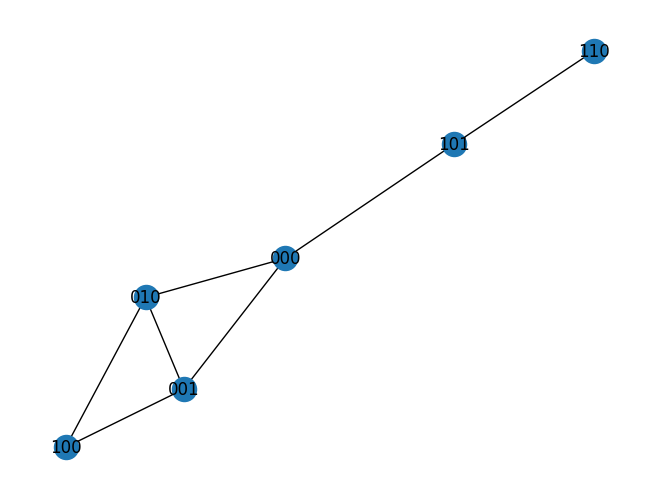

In [5]:
# Update the graph
h = nx.Graph()
for src, sinks in adjacency_list.items():
    for sink, weight in sinks.items():
        h.add_edge(src, sink, weight=weight)
nx.draw(h, with_labels=True)

In [6]:
# Initialize position qubits to superposition
qc.h(range(num_position_qubits))

# Initialize coin qubit(s)
qc.h(range(num_position_qubits, total_qubits))  


In [7]:
def initialize_positions(qc, position_qubits, valid_indices):
    num_qubits = len(position_qubits)
    num_states = len(valid_indices)
    # Create the desired superposition state vector
    state_vector = np.zeros(2 ** num_qubits)
    amplitude = 1 / np.sqrt(num_states)
    for idx in valid_indices:
        state_vector[idx] = amplitude
    # Use the StatePreparation circuit
    prep_circuit = StatePreparation(state_vector).inverse()
    qc.append(prep_circuit, position_qubits)
    return qc

In [8]:
def initialize_coin(qc, coin_qubits):
    qc.h(coin_qubits)
    return qc
def coin_operator(qc, coin_qubit):
    def grover_coin(qc, coin_qubits):
        qc.h(coin_qubits)
        qc.x(coin_qubits)
        # Apply multi-controlled Z gate
        if len(coin_qubits) > 1:
            qc.h(coin_qubits[-1])
            qc.mcx(coin_qubits[:-1], coin_qubits[-1])  # Multi-controlled Toffoli
            qc.h(coin_qubits[-1])
        else:
            qc.z(coin_qubits[0])
        qc.x(coin_qubits)
        qc.h(coin_qubits)
        return qc
    qc = grover_coin(qc, coin_qubits)
    return qc

In [9]:
def shift_operator(qc, position_qubits, coin_qubits, adjacency_list):
    num_position_qubits = len(position_qubits)
    num_coin_qubits = len(coin_qubits)
    
    for node, neighbors in adjacency_list.items():
        src_bin = node
        degree = node_valencies[node]
        
        # For each possible coin state
        for coin_value in range(2 ** num_coin_qubits):
            coin_bin = format(coin_value, f'0{num_coin_qubits}b')
            
            # Map coin state to neighbor index using modulo
            neighbor_idx = coin_value % degree
            dst_bin = neighbors[neighbor_idx]

            
            # Build control qubits list
            controls = []
            # Control on position qubits
            for qb, bit in zip(position_qubits, src_bin):
                if bit == '0':
                    qc.x(qb)
                controls.append(qb)
            # Control on coin qubits
            for qb, bit in zip(coin_qubits, coin_bin):
                if bit == '0':
                    qc.x(qb)
                controls.append(qb)
            
            # Apply NOT gates to change position to dst_bin
            for i, (q, src_bit, dst_bit) in enumerate(zip(position_qubits, src_bin, dst_bin)):
                if src_bit != dst_bit:
                    mcx_controls = [qb for qb in controls if qb != q]
                    qc.mcx(mcx_controls, q)
            
            # Uncompute controls on coin qubits
            for qb, bit in zip(coin_qubits, coin_bin):
                if bit == '0':
                    qc.x(qb)
            # Uncompute controls on position qubits
            for qb, bit in zip(position_qubits, src_bin):
                if bit == '0':
                    qc.x(qb)
    return qc


In [10]:
def demand_oracle(qc, position_qubits, unsatisfied_nodes):
    for idx in unsatisfied_nodes:
        idx_bin = format(idx, f'0{len(position_qubits)}b')
        controls = []
        for qb, bit in zip(position_qubits, idx_bin):
            if bit == '0':
                qc.x(qb)
            controls.append(qb)
        # Apply multi-controlled Z (phase flip)
        qc.cp(np.pi, controls, qc.qubits[-1])
        # Uncompute controls
        for qb, bit in zip(position_qubits, idx_bin):
            if bit == '0':
                qc.x(qb)
    return qc

In [11]:
# Define qubits
position_qubits = qc.qubits[:num_position_qubits]
coin_qubits = qc.qubits[num_position_qubits:num_position_qubits + num_coin_qubits]
valid_indices = [int(node, 2) for node in node_values.keys()]


# qc = initialize_positions(qc, position_qubits, valid_indices)

# Initialize coin qubits
qc = initialize_coin(qc, coin_qubits)

# Prepare unsatisfied nodes list
unsatisfied_nodes = []
for idx, node in enumerate(node_values.keys()):
    if node_capacities[node] < node_values[node]:
        unsatisfied_nodes.append(idx)

neighbors_dict = {node: [] for node in node_to_idx.values()}
for node, neighbors in adjacency_list.items():
    for neighbor in neighbors.keys():
        neighbors_dict[node].append(neighbor)
        neighbors_dict[neighbor].append(node)
for node, neighbors in neighbors_dict.items():
    neighbors_dict[node] = sorted(neighbors)

# Perform the quantum walk
num_steps = 2
for _ in range(num_steps):
    # Apply Grover coin operator
    qc = coin_operator(qc, coin_qubits)
    
    # Apply shift operator
    qc = shift_operator(qc, position_qubits, coin_qubits, neighbors_dict)
    


In [12]:
    # Apply demand oracle
    qc = demand_oracle(qc, position_qubits, unsatisfied_nodes)

In [13]:
# # Measure the position qubits
qc.measure(range(num_position_qubits), range(num_position_qubits))

# Choose the simulator backend
backend = AerSimulator()

# Transpile the circuit for the backend
transpiled_qc = transpile(qc, backend)

# Run the circuit on the simulator
job = backend.run(transpiled_qc, shots=1024)

# Get the results
result = job.result()

# Extract the counts
counts = result.get_counts(qc)

In [14]:
filtered_counts = {idx_to_node[k]: v for k, v in counts.items() if (k != '111' and k != '011')}
filtered_counts

{'Kulhudhuffushi': 121,
 'Male': 145,
 'Fuvahmulah': 135,
 'Addu_City': 126,
 'Naifaru': 120,
 'Thinadhoo': 122}

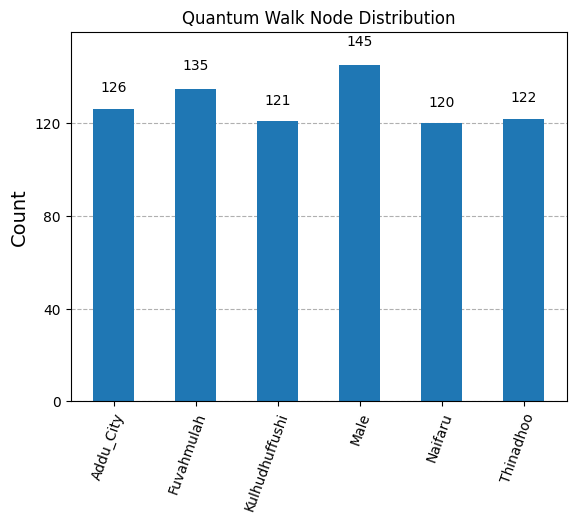

In [15]:
# Plot the results
plot_histogram(filtered_counts, title="Quantum Walk Node Distribution")

/tmp/ipykernel_30/1776167374.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')
/opt/conda/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/tmp/ipykernel_30/1776167374.py:64: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


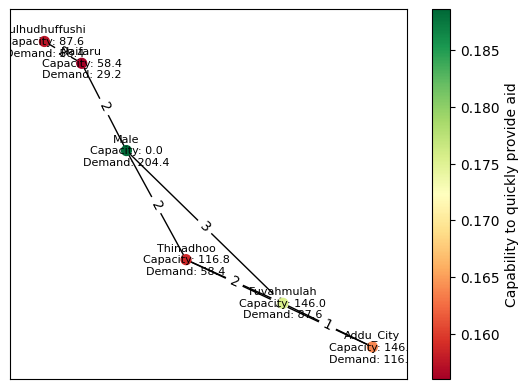

In [16]:
h = nx.Graph()
for src, sinks in adjacency_list.items():
    for sink, weight in sinks.items():
        h.add_edge(idx_to_node[src], idx_to_node[sink], weight=weight)

# Assuming 'counts' is the measurement result from the quantum circuit execution
total_counts = sum(filtered_counts.values())
node_probabilities = {}

for node_bin, count in filtered_counts.items():

    node_name = node_bin
    probability = count / total_counts
    node_probabilities[node_name] = probability
prob_values = list(node_probabilities.values())

# Normalize probabilities between 0 and 1
min_prob = min(prob_values)
max_prob = max(prob_values)
norm_probabilities = {
    node: (prob - min_prob) / (max_prob - min_prob) if max_prob > min_prob else 0.5
    for node, prob in node_probabilities.items()
}
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Choose a colormap (green to red)
cmap = plt.cm.get_cmap('RdYlGn')

# Create a color mapping for each node
node_colors = {
    node: cmap(norm_probabilities.get(node, 0))
    for node in h.nodes()
}
# Assuming you have 'node_capacities' and 'node_demands' dictionaries
node_labels = {
    node: f"{node}\nCapacity: {node_capacities.get(node_to_idx[node], 0)*29.2}\nDemand: {node_values.get(node_to_idx[node], 0)*29.2}"
    for node in h.nodes()
}
import networkx as nx

# Calculate positions for all nodes
pos = positions_raw  # or any other layout you prefer

# Draw nodes with colors
nodes = nx.draw_networkx_nodes(
    h,
    pos,
    node_color=[node_colors.get(node, (0.5, 0.5, 0.5)) for node in h.nodes()],
    cmap=cmap,
    node_size=50
)
# Draw edges
nx.draw_networkx_edges(h, pos)

# Draw labels
nx.draw_networkx_labels(h, pos, labels=node_labels, font_size=8)
edge_labels = nx.get_edge_attributes(h, 'weight')

# Draw the edge labels
nx.draw_networkx_edge_labels(h, pos, edge_labels=edge_labels)# Create colorbar as legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_prob, vmax=max_prob))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Capability to quickly provide aid')

# Show the plot
plt.figsize=(20,20)
plt.show()


In [17]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=bdc6392b2b0eb9284704fdc4f1d881209b4fb9171b0b429a3d5fe9058c3d7864
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [18]:
import pylatexenc
qc.draw(fold=260)

┌───┐┌───┐                                             ┌───┐┌───┐     ┌───┐┌───┐┌───┐     ┌───┐┌───┐     ┌───┐     ┌───┐               ┌───┐               ┌───┐               ┌───┐     ┌───┐          ┌───┐┌───┐          ┌───┐┌───┐┌───┐     ┌───┐┌───┐»
q_0: ┤ H ├┤ X ├──────────────────────────────────────────■──┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├─────┤ X ├──■────────────┤ X ├──■────────────┤ X ├──■────────────┤ X ├──■──┤ X ├───────■──┤ X ├┤ X ├──■────■──┤ X ├┤ X ├┤ X ├──■──┤ X ├┤ X ├»
     ├───┤├───┤                                          │  ├───┤├───┤┌─┴─┐├───┤├───┤└─┬─┘  │  ├───┤├───┤  │  ├───┤┌───┐└─┬─┘  │  ┌───┐┌───┐└─┬─┘┌─┴─┐┌───┐┌───┐└─┬─┘  │  ┌───┐┌───┐└─┬─┘┌─┴─┐├───┤     ┌─┴─┐└───┘└───┘┌─┴─┐  │  └───┘└───┘└─┬─┘┌─┴─┐└───┘└───┘»
q_1: ┤ H ├┤ X ├──────────────────────────────────────────■──┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──■────■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■────■──┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├──■────■──┤ X ├┤ X ├──■──┤ X ├┤ X ├─────┤ X ├──────────┤ X ├──■──────────────■──┤ X ├──────────»
     ├───┤├───┤                                        ┌─┴─┐├───┤├───┤└─┬─┘├───┤├───┤  │  ┌─┴─┐├───┤├───┤┌─┴─┐├───┤├───┤  │  ┌─┴─┐├───┤├───┤  │  └─┬─┘├───┤├───┤  │  ┌─┴─┐├───┤├───┤  │  └─┬─┘├───┤┌───┐└─┬─┘┌───┐┌───┐└─┬─┘┌─┴─┐┌───┐┌───┐  │  └─┬─┘┌───┐┌───┐»
q_2: ┤ H ├┤ X ├────────────────────────────────────────┤ X ├┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├──■────■──┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├──■────■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├──■────■──┤ X ├┤ X ├»
     ├───┤├───┤┌───┐┌───┐          ┌───┐┌───┐┌───┐     └─┬─┘├───┤├───┤  │  ├───┤└───┘  │  └─┬─┘└───┘└───┘└─┬─┘├───┤└───┘  │  └─┬─┘├───┤├───┤  │    │  ├───┤└───┘  │  └─┬─┘└───┘└───┘  │    │  ├───┤└───┘  │  ├───┤├───┤  │  └─┬─┘├───┤└───┘  │    │  └───┘└───┘»
q_3: ┤ H ├┤ H ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ X ├──■──┤ X ├───────■────■──────────────■──┤ X ├───────■────■──┤ X ├┤ X ├──■────■──┤ X ├───────■────■──────────────■────■──┤ X ├───────■──┤ X ├┤ X ├──■────■──┤ X ├───────■────■────────────»
     ├───┤├───┤├───┤├───┤┌───┐┌─┴─┐├───┤├───┤├───┤┌───┐  │  ├───┤└───┘  │  ├───┤       │    │  ┌───┐       │  ├───┤       │    │  ├───┤└───┘  │    │  ├───┤       │    │  ┌───┐       │    │  ├───┤       │  ├───┤└───┘  │    │  ├───┤       │    │  ┌───┐     »
q_4: ┤ H ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├──■──┤ X ├───────■──┤ X ├───────■────■──┤ X ├───────■──┤ X ├───────■────■──┤ X ├───────■────■──┤ X ├───────■────■──┤ X ├───────■────■──┤ X ├───────■──┤ X ├───────■────■──┤ X ├───────■────■──┤ X ├─────»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘     └───┘          └───┘               └───┘          └───┘               └───┘               └───┘               └───┘               └───┘          └───┘               └───┘               └───┘     »
c: 3/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
                                                                                                                                                                                                                                                               »
«          ┌───┐                                                                           ┌───┐     ┌───┐┌───┐          ┌───┐┌───┐┌───┐     ┌───┐┌───┐     ┌───┐     ┌───┐                                   ┌───┐                         ┌───┐               »
«q_0: ──■──┤ X ├───────■────■──────────────■────■──────────────■────■──────────────■────■──┤ X ├──■──┤ X ├┤ X ├──■────■──┤ X ├┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├─────┤ X ├──■──────────────■────■────────────┤ X ├──■──────────────■────■──┤ X ├───────────────»
«     ┌─┴─┐└───┘     ┌─┴─┐  │            ┌─┴─┐  │            ┌─┴─┐  │            ┌─┴─┐  │  ├───┤  │  ├───┤├───┤┌─┴─┐  │  ├───┤├───┤└─┬─┘  │  ├───┤├─